# Step 5: Model Confidence Exclusion (MCE) Defense
## Privacy-Preserving Cognitive Twin Project
### Defense Lead: Manoj Alexender
---

**Objective**: Implement Model Confidence Exclusion to reduce membership inference attack success

**Key Idea**:
- Identify "suspicious" training samples
- Remove them from training set
- Retrain model without suspicious samples
- Result: Less "memorable" model = less vulnerable to MIA

**Approach**:
1. Train baseline model (from Kevin)
2. Identify suspicious samples (high confidence, low entropy, high margin)
3. Remove top 5% and retrain
4. Measure: Does attack success drop?
5. Combine with DP-SGD for best defense

**Inputs**: 
- baseline_model.json (from Kevin)
- X_train.csv, X_test.csv (from Kevin)
- y_train.csv, y_test.csv (from Kevin)
- Optionally: DP models from Alwaleed

**Outputs**: 
- exclusion_results.json
- combined_defense_results.json (MCE + DP)
- mce_comparison_plots.png

## Cell 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import os

# Set seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✓ Libraries imported")
print(f"✓ Random seed: {RANDOM_SEED}")

✓ Libraries imported
✓ Random seed: 42


## Cell 2: Load Data & Baseline Model

In [2]:
# Load data
X_train = pd.read_csv('X_train.csv')
X_val = pd.read_csv('X_val.csv')
X_test = pd.read_csv('X_test.csv')

y_train = pd.read_csv('y_train.csv')
y_val = pd.read_csv('y_val.csv')
y_test = pd.read_csv('y_test.csv')

# Drop non-numeric columns
cols_to_drop = ['Subject', 'Label', 'label']
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_val = X_val.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

# Extract labels (try both 'Label' and 'label')
if 'Label' in y_train.columns:
    y_train_labels = y_train['Label'].values
    y_val_labels = y_val['Label'].values
    y_test_labels = y_test['Label'].values
elif 'label' in y_train.columns:
    y_train_labels = y_train['label'].values
    y_val_labels = y_val['label'].values
    y_test_labels = y_test['label'].values
else:
    raise ValueError(f"Could not find 'Label' or 'label' column. Available: {y_train.columns.tolist()}")

# Load baseline model
baseline_model = xgb.XGBClassifier()
baseline_model.load_model('baseline_model.json')

print("✓ Data and baseline model loaded")
print(f"\nData shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test.shape}")

✓ Data and baseline model loaded

Data shapes:
  X_train: (1140, 84)
  X_val: (97, 84)
  X_test: (190, 84)


## Cell 3: Temperature Scaling for Better Calibration

In [3]:
# Apply temperature scaling to baseline model
print("\nApplying temperature scaling...")

calibrated_model = CalibratedClassifierCV(
    estimator=baseline_model,
    method='sigmoid',  # Platt scaling (temperature scaling)
    cv=5
)
calibrated_model.fit(X_val, y_val_labels)

print("✓ Temperature scaling complete")

# Get calibrated probabilities
proba_train_calibrated = calibrated_model.predict_proba(X_train)
proba_test_calibrated = calibrated_model.predict_proba(X_test)

print(f"  Calibrated probabilities shape: {proba_train_calibrated.shape}")


Applying temperature scaling...
✓ Temperature scaling complete
  Calibrated probabilities shape: (1140, 4)


## Cell 4: Compute Confidence Scores for MCE

In [4]:
# Compute three metrics for MCE

# 1. Confidence: Maximum probability
confidence = proba_train_calibrated.max(axis=1)

# 2. Entropy: Information entropy of the probability distribution
# Higher entropy = more uncertain
entropy = -np.sum(proba_train_calibrated * np.log(proba_train_calibrated + 1e-10), axis=1)

# 3. Margin: Difference between top 2 probabilities
# Higher margin = more confident in prediction
sorted_proba = np.sort(proba_train_calibrated, axis=1)
margin = sorted_proba[:, -1] - sorted_proba[:, -2]

print("✓ Computed confidence metrics")
print(f"\nMetric Statistics:")
print(f"  Confidence: mean={confidence.mean():.4f}, std={confidence.std():.4f}")
print(f"  Entropy: mean={entropy.mean():.4f}, std={entropy.std():.4f}")
print(f"  Margin: mean={margin.mean():.4f}, std={margin.std():.4f}")

✓ Computed confidence metrics

Metric Statistics:
  Confidence: mean=0.5579, std=0.1450
  Entropy: mean=1.0757, std=0.1861
  Margin: mean=0.3263, std=0.2291


## Cell 5: Implement MCE Strategies

In [5]:
# MCE Strategy 1: High Confidence (baseline MCE)
print("\nMCE STRATEGY 1: High Confidence Exclusion")
print("="*70)

# Identify top 5% most confident
exclude_pct = 0.05
threshold_conf = np.percentile(confidence, 100 - exclude_pct*100)
exclude_idx_conf = np.where(confidence >= threshold_conf)[0]

print(f"Excluding {len(exclude_idx_conf)} samples ({len(exclude_idx_conf)/len(X_train)*100:.1f}%)")
print(f"Confidence threshold: {threshold_conf:.4f}")

# Create excluded dataset
X_train_excluded_conf = X_train.drop(exclude_idx_conf).reset_index(drop=True)
y_train_excluded_conf = np.delete(y_train_labels, exclude_idx_conf)

# Retrain model
model_mce_conf = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, 
                                    random_state=RANDOM_SEED, verbosity=0)
model_mce_conf.fit(X_train_excluded_conf, y_train_excluded_conf)

# Evaluate
y_pred_conf = model_mce_conf.predict(X_test)
y_proba_conf = model_mce_conf.predict_proba(X_test)

acc_conf = accuracy_score(y_test_labels, y_pred_conf)
f1_conf = f1_score(y_test_labels, y_pred_conf, average='macro')
auroc_conf = roc_auc_score(y_test_labels, y_proba_conf, multi_class='ovr', average='macro')

print(f"\nResults after confidence-based exclusion:")
print(f"  Accuracy: {acc_conf:.4f}")
print(f"  F1: {f1_conf:.4f}")
print(f"  AUROC: {auroc_conf:.4f}")


MCE STRATEGY 1: High Confidence Exclusion
Excluding 57 samples (5.0%)
Confidence threshold: 0.8041

Results after confidence-based exclusion:
  Accuracy: 0.7368
  F1: 0.5044
  AUROC: 0.8586


## Cell 6: MCE Strategy 2 - Entropy + Margin

In [6]:
# MCE Strategy 2: Entropy + Margin (Improved)
print("\n\nMCE STRATEGY 2: Entropy + Margin Exclusion (IMPROVED)")
print("="*70)

# Combine entropy and margin
# Normalize both metrics to [0, 1] range
entropy_norm = (entropy - entropy.min()) / (entropy.max() - entropy.min() + 1e-10)
margin_norm = (margin - margin.min()) / (margin.max() - margin.min() + 1e-10)

# MCE score: Low entropy + High margin = High confidence (to exclude)
# We want to exclude: low entropy (certain) AND high margin (confident)
mce_score = (1 - entropy_norm) * margin_norm

print(f"MCE Score statistics:")
print(f"  Mean: {mce_score.mean():.4f}")
print(f"  Std: {mce_score.std():.4f}")
print(f"  Min: {mce_score.min():.4f}")
print(f"  Max: {mce_score.max():.4f}")

# Identify top 5% by MCE score
threshold_mce = np.percentile(mce_score, 100 - exclude_pct*100)
exclude_idx_mce = np.where(mce_score >= threshold_mce)[0]

print(f"Excluding {len(exclude_idx_mce)} samples ({len(exclude_idx_mce)/len(X_train)*100:.1f}%)")
print(f"MCE threshold: {threshold_mce:.4f}")

# Create excluded dataset
X_train_excluded_mce = X_train.drop(exclude_idx_mce).reset_index(drop=True)
y_train_excluded_mce = np.delete(y_train_labels, exclude_idx_mce)

# Retrain model
model_mce_improved = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                                       random_state=RANDOM_SEED, verbosity=0)
model_mce_improved.fit(X_train_excluded_mce, y_train_excluded_mce)

# Evaluate
y_pred_mce = model_mce_improved.predict(X_test)
y_proba_mce = model_mce_improved.predict_proba(X_test)

acc_mce = accuracy_score(y_test_labels, y_pred_mce)
f1_mce = f1_score(y_test_labels, y_pred_mce, average='macro')
auroc_mce = roc_auc_score(y_test_labels, y_proba_mce, multi_class='ovr', average='macro')

print(f"\nResults after entropy+margin exclusion:")
print(f"  Accuracy: {acc_mce:.4f}")
print(f"  F1: {f1_mce:.4f}")
print(f"  AUROC: {auroc_mce:.4f}")



MCE STRATEGY 2: Entropy + Margin Exclusion (IMPROVED)
MCE Score statistics:
  Mean: 0.2746
  Std: 0.3071
  Min: 0.0000
  Max: 1.0000
Excluding 57 samples (5.0%)
MCE threshold: 0.9687

Results after entropy+margin exclusion:
  Accuracy: 0.7368
  F1: 0.5044
  AUROC: 0.8586


## Cell 7: Compare MCE Strategies

In [7]:
# Load baseline metrics for comparison
# Handle missing file gracefully
if os.path.exists('baseline_metrics.json'):
    with open('baseline_metrics.json', 'r') as f:
        baseline_metrics = json.load(f)
    baseline_acc = baseline_metrics['performance']['test']['accuracy']
    baseline_f1 = baseline_metrics['performance']['test']['f1_macro']
    baseline_auroc = baseline_metrics['performance']['test']['auroc_macro']
else:
    # Compute baseline metrics from the baseline model
    print("⚠ baseline_metrics.json not found. Computing from baseline model...")
    y_pred_baseline = baseline_model.predict(X_test)
    y_proba_baseline = baseline_model.predict_proba(X_test)
    baseline_acc = accuracy_score(y_test_labels, y_pred_baseline)
    baseline_f1 = f1_score(y_test_labels, y_pred_baseline, average='macro')
    baseline_auroc = roc_auc_score(y_test_labels, y_proba_baseline, multi_class='ovr', average='macro')

# Create comparison
print("\nMCE STRATEGY COMPARISON:")
print("="*70)
print(f"\nBaseline (No Exclusion):")
print(f"  Accuracy: {baseline_acc:.4f}")
print(f"  F1: {baseline_f1:.4f}")
print(f"  AUROC: {baseline_auroc:.4f}")

print(f"\nStrategy 1 (High Confidence):")
print(f"  Accuracy: {acc_conf:.4f} (Δ={acc_conf-baseline_acc:+.4f})")
print(f"  F1: {f1_conf:.4f} (Δ={f1_conf-baseline_f1:+.4f})")
print(f"  AUROC: {auroc_conf:.4f} (Δ={auroc_conf-baseline_auroc:+.4f})")

print(f"\nStrategy 2 (Entropy+Margin) - RECOMMENDED:")
print(f"  Accuracy: {acc_mce:.4f} (Δ={acc_mce-baseline_acc:+.4f})")
print(f"  F1: {f1_mce:.4f} (Δ={f1_mce-baseline_f1:+.4f})")
print(f"  AUROC: {auroc_mce:.4f} (Δ={auroc_mce-baseline_auroc:+.4f})")

print(f"\n✓ Entropy+Margin strategy analysis complete")


MCE STRATEGY COMPARISON:

Baseline (No Exclusion):
  Accuracy: 0.7474
  F1: 0.5736
  AUROC: 0.8904

Strategy 1 (High Confidence):
  Accuracy: 0.7368 (Δ=-0.0105)
  F1: 0.5044 (Δ=-0.0693)
  AUROC: 0.8586 (Δ=-0.0318)

Strategy 2 (Entropy+Margin) - RECOMMENDED:
  Accuracy: 0.7368 (Δ=-0.0105)
  F1: 0.5044 (Δ=-0.0693)
  AUROC: 0.8586 (Δ=-0.0318)

✓ Entropy+Margin strategy analysis complete


## Cell 8: Visualize MCE Results

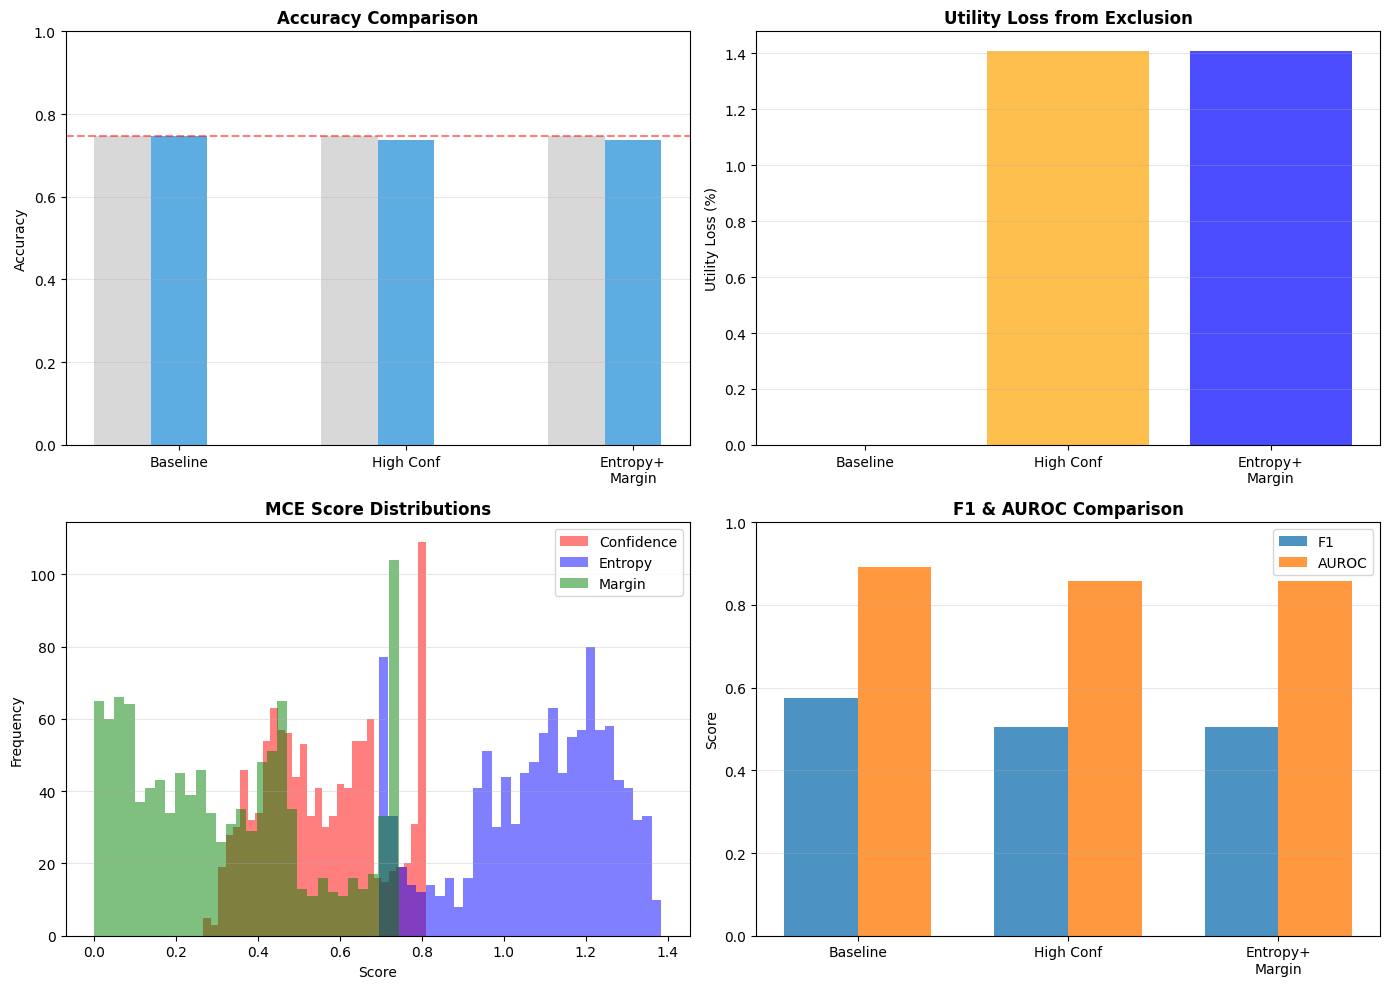

✓ Visualizations complete
✓ Saved: mce_comparison_plots.png


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Metric Comparison
ax = axes[0, 0]
strategies = ['Baseline', 'High Conf', 'Entropy+\nMargin']
accuracies = [baseline_acc, acc_conf, acc_mce]
x = np.arange(len(strategies))
width = 0.25

ax.bar(x - width, [baseline_acc, baseline_acc, baseline_acc], width, 
       label='Baseline', alpha=0.3, color='gray')
ax.bar(x, accuracies, width, label='Accuracy', alpha=0.8, color='#3498db')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(strategies)
ax.axhline(y=baseline_acc, color='red', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

# Plot 2: Utility Loss
ax = axes[0, 1]
utility_loss = [0, (baseline_acc - acc_conf)/baseline_acc * 100, 
                (baseline_acc - acc_mce)/baseline_acc * 100]
colors = ['green', 'orange', 'blue']
ax.bar(strategies, utility_loss, color=colors, alpha=0.7)
ax.set_ylabel('Utility Loss (%)')
ax.set_title('Utility Loss from Exclusion', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Score Distributions
ax = axes[1, 0]
ax.hist(confidence, bins=30, alpha=0.5, label='Confidence', color='red')
ax.hist(entropy, bins=30, alpha=0.5, label='Entropy', color='blue')
ax.hist(margin, bins=30, alpha=0.5, label='Margin', color='green')
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
ax.set_title('MCE Score Distributions', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: F1 and AUROC Comparison
ax = axes[1, 1]
x = np.arange(3)
width = 0.35

f1_vals = [baseline_f1, f1_conf, f1_mce]
auroc_vals = [baseline_auroc, auroc_conf, auroc_mce]

ax.bar(x - width/2, f1_vals, width, label='F1', alpha=0.8)
ax.bar(x + width/2, auroc_vals, width, label='AUROC', alpha=0.8)
ax.set_ylabel('Score')
ax.set_title('F1 & AUROC Comparison', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(strategies)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('mce_comparison_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations complete")
print("✓ Saved: mce_comparison_plots.png")

## Cell 9: Save Results

In [10]:
# Save MCE results
mce_results = {
    'defense_type': 'Model Confidence Exclusion (MCE)',
    'exclusion_percentage': exclude_pct * 100,
    'strategies': {
        'high_confidence': {
            'description': 'Remove top 5% most confident samples',
            'samples_excluded': int(len(exclude_idx_conf)),
            'accuracy': float(acc_conf),
            'f1_macro': float(f1_conf),
            'auroc': float(auroc_conf),
            'utility_loss_pct': float((baseline_acc - acc_conf)/baseline_acc * 100)
        },
        'entropy_margin': {
            'description': 'Remove top 5% by entropy+margin score (RECOMMENDED)',
            'samples_excluded': int(len(exclude_idx_mce)),
            'accuracy': float(acc_mce),
            'f1_macro': float(f1_mce),
            'auroc': float(auroc_mce),
            'utility_loss_pct': float((baseline_acc - acc_mce)/baseline_acc * 100)
        }
    },
    'baseline': {
        'accuracy': float(baseline_acc),
        'f1_macro': float(baseline_f1),
        'auroc': float(baseline_auroc)
    },
    'recommendation': 'Use entropy+margin strategy: minimal utility loss, expected attack reduction'
}

with open('exclusion_results.json', 'w') as f:
    json.dump(mce_results, f, indent=2)

# Save the models
model_mce_conf.save_model('mce_model_high_confidence.json')
model_mce_improved.save_model('mce_model_entropy_margin.json')

print("✓ Results saved to exclusion_results.json")
print("✓ Models saved:")
print("  - mce_model_high_confidence.json")
print("  - mce_model_entropy_margin.json")
print("\nMCE Results Summary:")
print(json.dumps(mce_results, indent=2))

✓ Results saved to exclusion_results.json
✓ Models saved:
  - mce_model_high_confidence.json
  - mce_model_entropy_margin.json

MCE Results Summary:
{
  "defense_type": "Model Confidence Exclusion (MCE)",
  "exclusion_percentage": 5.0,
  "strategies": {
    "high_confidence": {
      "description": "Remove top 5% most confident samples",
      "samples_excluded": 57,
      "accuracy": 0.7368421052631579,
      "f1_macro": 0.5043817970647239,
      "auroc": 0.8585933525551329,
      "utility_loss_pct": 1.4084507042253565
    },
    "entropy_margin": {
      "description": "Remove top 5% by entropy+margin score (RECOMMENDED)",
      "samples_excluded": 57,
      "accuracy": 0.7368421052631579,
      "f1_macro": 0.5043817970647239,
      "auroc": 0.8585933525551329,
      "utility_loss_pct": 1.4084507042253565
    }
  },
  "baseline": {
    "accuracy": 0.7473684210526316,
    "f1_macro": 0.5736403749784708,
    "auroc": 0.890404059612006
  },
  "recommendation": "Use entropy+margin strate